<h1>Pre-Processing</h1>
<ul>
	<li>Equalize histogram</li>
	<li>Resize</li>
	<li>Save Data</li>
</ul>

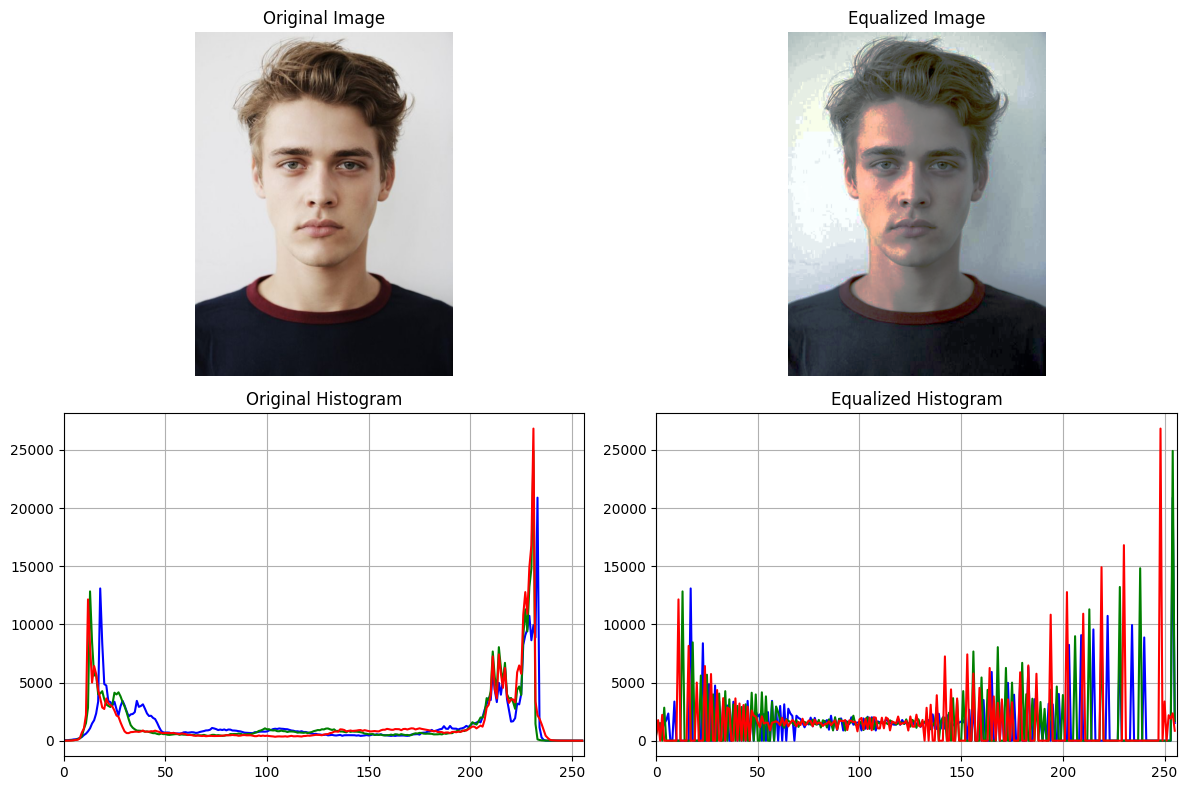

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def histogram_equalization(img):
	flat = img.flatten()
	hist = [0] * 256
	for pixel in flat:
		hist[pixel] += 1

	cdf = [0] * 256
	cdf[0] = hist[0]
	for i in range(1, 256):
		cdf[i] = cdf[i-1] + hist[i]
	cdf_min = min([x for x in cdf if x > 0])
	total = flat.size

	lut = [0] * 256
	for i in range(256):
		lut[i] = round((cdf[i] - cdf_min) / (total - cdf_min) * 255)
		lut[i] = max(0, min(255, lut[i]))

	equalized = [lut[p] for p in flat]
	return np.array(equalized, dtype=np.uint8).reshape(img.shape)

def histogram_equalization_color(img):
  out = np.zeros_like(img)
  for c in range(3):
      out[..., c] = histogram_equalization(img[..., c])
  return out

sample_image_path = 'Data/1 (1072).jpg'
sample_image = cv2.imread(sample_image_path)

equalized_image = histogram_equalization_color(sample_image)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))
plt.title('Equalized Image')
plt.axis('off')

plt.subplot(2, 2, 3)
for i, color in enumerate(['b', 'g', 'r']):
	hist = cv2.calcHist([sample_image], [i], None, [256], [0, 256])
	plt.plot(hist, color=color)
plt.title('Original Histogram')
plt.xlim([0, 256])
plt.grid(True)

plt.subplot(2, 2, 4)
for i, color in enumerate(['b', 'g', 'r']):
	hist = cv2.calcHist([equalized_image], [i], None, [256], [0, 256])
	plt.plot(hist, color=color)
plt.title('Equalized Histogram')
plt.xlim([0, 256])
plt.grid(True)

plt.tight_layout()
plt.show()

In [2]:
def resize_image(img, new_width, new_height):
	h, w = img.shape[:2]
	if len(img.shape) == 3:
		c = img.shape[2]
		resized = np.zeros((new_height, new_width, c), dtype=img.dtype)
	else:
		resized = np.zeros((new_height, new_width), dtype=img.dtype)

	for i in range(new_height):
		for j in range(new_width):
			src_x = int(j * w / new_width)
			src_y = int(i * h / new_height)
			src_x = min(src_x, w - 1)
			src_y = min(src_y, h - 1)
			resized[i, j] = img[src_y, src_x]
	return resized

In [3]:
def bgr_to_rgb(img):
	return img[..., ::-1]

In [4]:
import cv2
import mediapipe as mp

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

face_detection = mp_face_detection.FaceDetection(
	model_selection=1,
	min_detection_confidence=0.5
)

def faceDetect_resize_equalize(image):
	image_rgb = bgr_to_rgb(image)

	results = face_detection.process(image_rgb)

	if results.detections:
		for i, detection in enumerate(results.detections):
			bboxC = detection.location_data.relative_bounding_box
			ih, iw, _ = image.shape

			x = int(bboxC.xmin * iw)
			y = int(bboxC.ymin * ih)
			w = int(bboxC.width * iw)
			h = int(bboxC.height * ih)

			face_img = image[y:y+h, x:x+w]
			try:
				face_img = resize_image(histogram_equalization(face_img), 400, 400)
			except Exception as e:
				print(f"Error processing face image: {e}")
				return None
			return face_img
	else:
		return None

# Feature extraction
<ul>
	<li>LBP</li>
	<li>HOG</li>
	<li>Face landmark</li>
</ul>

        ### Extract lbp - uniform

In [6]:

import matplotlib.pyplot as plt

def extract_uniform_lbp(image, radius=2, points=8):
	if len(image.shape) == 3:
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	else:
		gray = image
	
	height, width = gray.shape
	lbp_image = np.zeros((height, width), dtype=np.uint8)
	
	uniform_patterns = []
	for i in range(0, 2**points):
		bitstring = format(i, f'0{points}b')
		transitions = 0
		for j in range(points):
			transitions += (bitstring[j] != bitstring[(j+1) % points])
		
		if transitions <= 2:
			uniform_patterns.append(i)
	
	n_patterns = len(uniform_patterns)
	uniform_map = {pattern: idx for idx, pattern in enumerate(uniform_patterns)}
	
	for y in range(radius, height - radius):
		for x in range(radius, width - radius):
			center = gray[y, x]
			binary = 0
			
			for p in range(points):
				angle = 2 * np.pi * p / points
				x_p = int(round(x + radius * np.cos(angle)))
				y_p = int(round(y + radius * np.sin(angle)))
				
				if gray[y_p, x_p] >= center:
					binary |= (1 << p)
			
			if binary in uniform_map:
				lbp_image[y, x] = uniform_map[binary]
			else:
				lbp_image[y, x] = n_patterns
	
	hist, _ = np.histogram(lbp_image, bins=n_patterns+1, range=(0, n_patterns))
	print(hist)
	
	hist = hist.astype("float") / hist.sum()
	
	return hist

        ### Extract HOG

In [7]:
def bgr_to_gray(image):
	b = image[..., 0].astype(np.float32)
	g = image[..., 1].astype(np.float32)
	r = image[..., 2].astype(np.float32)
	gray = 0.114 * b + 0.587 * g + 0.299 * r
	return gray.astype(np.uint8)

In [8]:
def manual_sobel_x(image):
	if len(image.shape) > 2:
			raise ValueError("Đầu vào phải là ảnh grayscale")
	image = image.astype(np.float64)
	height, width = image.shape
	gradient_x = np.zeros((height, width), dtype=np.float64)
	for y in range(height):
			for x in range(1, width - 1):
					gradient_x[y, x] = image[y, x + 1] - image[y, x - 1]
	for y in range(height):
			gradient_x[y, 0] = image[y, 1] - image[y, 0]
	
	for y in range(height):
			gradient_x[y, width - 1] = image[y, width - 1] - image[y, width - 2]
	
	return gradient_x

def manual_sobel_y(image):
	if len(image.shape) > 2:
			raise ValueError("Đầu vào phải là ảnh grayscale")
	image = image.astype(np.float64)
	
	height, width = image.shape
	
	gradient_y = np.zeros((height, width), dtype=np.float64)

	for y in range(1, height - 1):
			for x in range(width):
					gradient_y[y, x] = image[y + 1, x] - image[y - 1, x]

	for x in range(width):
			gradient_y[0, x] = image[1, x] - image[0, x]
	
	for x in range(width):
			gradient_y[height - 1, x] = image[height - 1, x] - image[height - 2, x]
	
	return gradient_y

In [9]:
def extract_hog_features(image, cell_size=8, block_size=2, bins=9):
	if len(image.shape) == 3:
		gray = bgr_to_gray(image)
	else:
		gray = image.copy()
		
	height, width = gray.shape
	
	gx = manual_sobel_x(gray)
	gy = manual_sobel_y(gray)

	magnitude = np.sqrt(gx**2 + gy**2)
	orientation = np.arctan2(gy, gx) * (180 / np.pi) % 180
	
	n_cells_y = height // cell_size
	n_cells_x = width // cell_size
	
	hog_cells = np.zeros((n_cells_y, n_cells_x, bins))
	
	for y in range(n_cells_y):
		for x in range(n_cells_x):
			cell_magnitude = magnitude[y*cell_size:(y+1)*cell_size, 
										x*cell_size:(x+1)*cell_size]
			cell_orientation = orientation[y*cell_size:(y+1)*cell_size, 
											x*cell_size:(x+1)*cell_size]
			
			for i in range(cell_size):
				for j in range(cell_size):
					if y*cell_size+i < height and x*cell_size+j < width:
						grad_mag = cell_magnitude[i, j]
						grad_ang = cell_orientation[i, j]
						
						bin_index = int(grad_ang / (180.0 / bins)) % bins
						hog_cells[y, x, bin_index] += grad_mag
	
	n_blocks_y = n_cells_y - block_size + 1
	n_blocks_x = n_cells_x - block_size + 1
	normalized_blocks = np.zeros((n_blocks_y, n_blocks_x, block_size * block_size * bins))
	
	for y in range(n_blocks_y):
		for x in range(n_blocks_x):
			block = hog_cells[y:y+block_size, x:x+block_size, :].flatten()
			block_norm = np.sqrt(np.sum(block**2) + 1e-10)
			if block_norm > 0:
				block = block / block_norm
			normalized_blocks[y, x, :] = block
	
	hog_features = normalized_blocks.flatten()
	
	# plt.figure(figsize=(12, 6))
	# plt.subplot(121)
	# plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
	# plt.title("Original Image")
	# plt.subplot(122)
	# plt.plot(hog_features)
	# plt.title("HOG Feature Vector")
	# plt.tight_layout()
	# plt.show()
	
	# print(f"HOG feature vector shape: {hog_features.shape}")
	
	return hog_features

# cell_size = 8
# block_size = 2
# bins = 9
# hog_features = extract_hog_features(face_img, cell_size=cell_size, block_size=block_size, bins=bins)

In [10]:
import os
def load_hogs(folder):
  hogs = []
  for filename in os.listdir(folder):
      path = os.path.join(folder, filename)
      img = cv2.imread(path)
      if img is not None:
          img = cv2.resize(img, (400,400))
          hog = extract_hog_features(img)
          hogs.append(hog)
  return hogs


In [11]:

from sklearn.decomposition import TruncatedSVD

X_hog = load_hogs('Data')
print(f"Loaded HOG features: shape = {np.array(X_hog).shape}")

N_COMPONENTS = 300
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)
X_hog_reduced = svd.fit_transform(X_hog)

explained_variance_ratio = svd.explained_variance_ratio_.sum()
print(f"Variance explained: {explained_variance_ratio:.4f} ({explained_variance_ratio*100:.2f}%)")
print(f"Reduced HOG features: shape = {X_hog_reduced.shape}")

import pickle
hog_svd_model = {
	'svd': svd
}
with open('hog_svd_model.pkl', 'wb') as f:
	pickle.dump(hog_svd_model, f)

KeyboardInterrupt: 

        ### Extract face landmarks

In [12]:
def extract_face_landmarks(image):
  mp_face_mesh = mp.solutions.face_mesh
  face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)
  
  rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  results = face_mesh.process(rgb_image)
  
  if not results.multi_face_landmarks:
    return np.zeros(10)  
  
  landmarks = results.multi_face_landmarks[0].landmark
  
  h, w = image.shape[:2]
  landmarks_array = np.array([[lm.x * w, lm.y * h] for lm in landmarks])
  
  left_eye = landmarks_array[33]
  right_eye = landmarks_array[263]
  nose_tip = landmarks_array[1]
  mouth_left = landmarks_array[61]
  mouth_right = landmarks_array[291]
  
  chin = landmarks_array[152]       
  forehead = landmarks_array[10]    
  left_eyebrow = landmarks_array[107] 
  right_eyebrow = landmarks_array[336] 
  
  ratios = []
  
  eyes_distance = np.linalg.norm(left_eye - right_eye)
  face_width = np.linalg.norm(landmarks_array[234] - landmarks_array[454])
  ratios.append(eyes_distance / face_width)
  
  left_eye_nose_distance = np.linalg.norm(left_eye - nose_tip)
  face_height = np.linalg.norm(forehead - chin)
  ratios.append(left_eye_nose_distance / face_height)
  
  nose_mouth_distance = (np.linalg.norm(nose_tip - mouth_left) + np.linalg.norm(nose_tip - mouth_right)) / 2
  ratios.append(nose_mouth_distance / face_height)
  
  mouth_width = np.linalg.norm(mouth_left - mouth_right)
  ratios.append(mouth_width / face_width)
  
  right_eye_mouth_distance = np.linalg.norm(right_eye - mouth_right)
  ratios.append(right_eye_mouth_distance / face_height)

  forehead_nose_distance = np.linalg.norm(forehead - nose_tip)
  ratios.append(forehead_nose_distance / face_height)
  
  nose_chin_distance = np.linalg.norm(nose_tip - chin)
  ratios.append(nose_chin_distance / face_height)
  
  eyebrows_distance = np.linalg.norm(left_eyebrow - right_eyebrow)
  ratios.append(eyebrows_distance / face_width)
  
  ratios.append(face_height / face_width)
  
  left_eye_to_eyebrow = np.linalg.norm(left_eye - left_eyebrow)
  right_eye_to_eyebrow = np.linalg.norm(right_eye - right_eyebrow)
  eye_eyebrow_avg_distance = (left_eye_to_eyebrow + right_eye_to_eyebrow) / 2
  ratios.append(eye_eyebrow_avg_distance / face_height)
  
  return np.array(ratios)

        ### PCA

<li>Train PCA</li>

In [33]:
import os
def load_images(folder, size):
  images = []
  for filename in os.listdir(folder):
      path = os.path.join(folder, filename)
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      if img is not None:
          img = cv2.resize(img, size)
          images.append(img.flatten())
  return np.array(images)

In [34]:
IMAGE_SIZE = (64, 64) 
N_COMPONENTS = 150
X = load_images('Data', IMAGE_SIZE)
print(f"Loaded {X.shape[0]} images, mỗi ảnh có {X.shape[1]} pixel")

mean_vector = np.mean(X, axis=0)
X_centered = X - mean_vector

cov_matrix = np.cov(X_centered, rowvar=False)  

eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

idx_sorted = np.argsort(eigenvalues)[::-1]
eigenvectors_sorted = eigenvectors[:, idx_sorted]
eigenvalues_sorted = eigenvalues[idx_sorted]

components = eigenvectors_sorted[:, :N_COMPONENTS]

X_pca = np.dot(X_centered, components)

# Tính tổng phương sai giữ lại
total_variance = np.sum(eigenvalues)
retained_variance = np.sum(eigenvalues_sorted[:N_COMPONENTS])
retained_ratio = retained_variance / total_variance

print(f"Tổng phương sai giữ lại: {retained_ratio:.4f} ({retained_ratio*100:.2f}%)")

print(f"Dữ liệu sau PCA: shape = {X_pca.shape}")

Loaded 354 images, mỗi ảnh có 4096 pixel
Tổng phương sai giữ lại: 0.9601 (96.01%)
Dữ liệu sau PCA: shape = (354, 150)


In [35]:
import pickle
pca_model = {
	'mean': mean_vector,
	'components': components
}
with open('pca_manual.pkl', 'wb') as f:
    pickle.dump(pca_model, f)

In [36]:
with open('pca_manual.pkl', 'rb') as f:
  model = pickle.load(f)

mean_vector = model['mean']
components = model['components']

def process_new_image(img, size):
	img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	img = cv2.resize(img, size)
	img_flat = img.flatten()
	return img_flat

def extract_pca_features(img):
	img_centered = img - mean_vector
	img_pca = np.dot(img_centered, components)
	return img_pca


        #### Extract All

In [ ]:
images = []
features_db = []
i = 1

with open('hog_svd_model.pkl', 'rb') as f:
    hog_svd_model = pickle.load(f)
svd = hog_svd_model['svd']
weight_landmarks = 3.0 

for f in os.listdir('Data'):
	imgHandled = faceDetect_resize_equalize(cv2.imread(os.path.join('Data', f)))
	if imgHandled is not None:
		lbp_features = extract_uniform_lbp(imgHandled)
		hog_features = svd.transform([extract_hog_features(imgHandled)])[0]
		landmarks_features = extract_face_landmarks(imgHandled)
		pca_features = extract_pca_features(process_new_image(imgHandled, IMAGE_SIZE))
		print("shape lbp:", lbp_features.shape)
		print("shape hog:", hog_features.shape)
		print("shape landmarks:", landmarks_features.shape)
		print("shape pca:", pca_features.shape)
		combined_features = np.concatenate([
			(hog_features / np.linalg.norm(hog_features)) * (1 / np.sqrt(len(hog_features))),
			(lbp_features / np.linalg.norm(lbp_features)) * (1 / np.sqrt(len(lbp_features))),
			((landmarks_features / np.linalg.norm(landmarks_features)) * weight_landmarks) if np.linalg.norm(landmarks_features) > 0 else landmarks_features,
			(pca_features / np.linalg.norm(pca_features)) * (1 / np.sqrt(len(pca_features)))
		])
		
		print(i)
		i+=1
		features_db.append({
				'path': 'Data/' + f,
				'features': combined_features
		})


In [31]:
print(features_db[0])

{'path': 'Data/1 (101).jpg', 'features': array([ 0.00536254,  0.        ,  0.00084264, ..., -0.02213753,
       -0.00450334,  0.03517432])}


In [50]:
with open('feature_dbs.pkl', 'wb') as f:
    pickle.dump(features_db, f)

In [19]:
with open('hog_svd_model.pkl', 'rb') as f:
    hog_svd_model = pickle.load(f)

svd = hog_svd_model['svd']

[12282  1332  1588   738  1329   729  1090  1323   750   887  1737  1472
   885  1218  1639  2102  1707   984  1316  2333  1331  1054  1529   952
  1148  2205  2076  1229  1880  1258   705  1071  2189  1277  1086  2753
   814   890  1766  1566  1020  2033  1060  1492   971   884  2021  1573
  1593   985  1624  1343  1137  2208  1141  2100  2618 22336 45641]
shape lbp: (59,)
shape hog: (300,)
shape landmarks: (10,)
shape pca: (150,)
Top 3 similar images:
1. Data/1 (850).jpg - Similarity: 1.0000
2. Data/1 (676).jpg - Similarity: 0.9997
3. Data/1 (931).jpg - Similarity: 0.9997


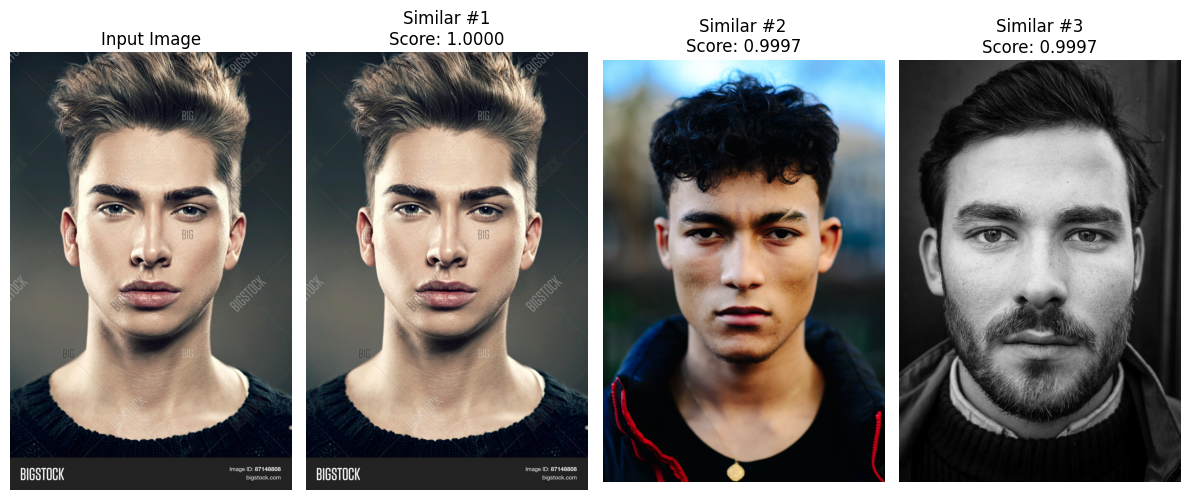

In [38]:
def find_similar_images(input_image_path, features_db, top_n=3):
  input_img = faceDetect_resize_equalize(cv2.imread(input_image_path))
  
  if input_img is None:
    print("Failed to process input image")
    return []
  
  input_lbp = extract_uniform_lbp(input_img)
  input_hog = svd.transform([extract_hog_features(input_img)])[0]
  input_landmarks = extract_face_landmarks(input_img)
  input_pca = extract_pca_features(process_new_image(input_img, IMAGE_SIZE))
  print("shape lbp:", input_lbp.shape)
  print("shape hog:", input_hog.shape)
  print("shape landmarks:", input_landmarks.shape)
  print("shape pca:", input_pca.shape)
  
  input_combined = np.concatenate([
    (input_hog / np.linalg.norm(input_hog)) * (1 / np.sqrt(len(input_hog))),
    (input_lbp / np.linalg.norm(input_lbp)) * (1 / np.sqrt(len(input_lbp))),
    ((input_landmarks / np.linalg.norm(input_landmarks)) * weight_landmarks) if np.linalg.norm(input_landmarks) > 0 else input_landmarks,
    (input_pca / np.linalg.norm(input_pca)) * (1 / np.sqrt(len(input_pca)))
  ])
  
  similarity_scores = []
  for item in features_db:
    similarity = np.dot(input_combined, item['features']) / (
      np.linalg.norm(input_combined) * np.linalg.norm(item['features']))
    similarity_scores.append((item['path'], similarity))
  
  similarity_scores.sort(key=lambda x: x[1], reverse=True)
  
  return similarity_scores[:top_n]

with open('feature_dbs.pkl', 'rb') as f:
  features_db = pickle.load(f)


input_image = "Data/1 (850).jpg"
similar_images = find_similar_images(input_image, features_db)


print("Top 3 similar images:")
for i, (path, score) in enumerate(similar_images, 1):
  print(f"{i}. {path} - Similarity: {score:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))


plt.subplot(1, 4, 1)
input_img = cv2.imread(input_image)
input_img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.imshow(input_img_rgb)
plt.title("Input Image")
plt.axis('off')

for i, (path, score) in enumerate(similar_images, 2):
  plt.subplot(1, 4, i)
  img = cv2.imread(path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_rgb)
  plt.title(f"Similar #{i-1}\nScore: {score:.4f}")
  plt.axis('off')

plt.tight_layout()
plt.show()